In [2]:
%reload_ext autoreload
%autoreload 3

import matplotlib.pyplot as plt


In [3]:
%%script echo skipping...
# webview

import cortex
cortex.webshow(cortex.Volume.random("S1", "fullhead"))

skipping...


In [4]:
%%script echo skipping...

# left, right = cortex.db.S1.surfaces.inflated.get()
# cortex.db.S1.surfaces.flat.show()

skipping...


In [5]:
%%script echo skipping...

import cortex

subject = "S1"
xfm = "fullhead"
roi = "EBA"

# Get the map of which voxels are inside of our ROI
roi_masks = cortex.utils.get_roi_masks(subject, xfm,
                                       roi_list=[roi],
                                       gm_sampler='cortical-conservative', # Select only voxels mostly within cortex
                                       split_lr=False, # No separate left/right ROIs
                                       threshold=None, # Leave roi mask values as probabilites / fractions
                                       return_dict=True
                                       )

# # Plot the mask for one ROI onto a flatmap
roi_data = cortex.Volume(roi_masks[roi], subject, xfm,
                         vmin=0, # This is a probability mask, so only
                         vmax=1, # so scale btw zero and one
                         cmap="inferno", # For pretty
                         )

cortex.quickflat.make_figure(roi_data,
                             thick=1, # select a single depth (btw white matter & pia)
                             sampler='nearest', # no interpolation
                             with_curvature=False,
                             with_colorbar=True,
                             )

plt.show()

skipping...


In [6]:
%%script echo skipping...

from nilearn import datasets
from nilearn import plotting, image

smith_atlas = datasets.fetch_atlas_smith_2009()
rsn10_img = smith_atlas.rsn10

img = image.index_img(rsn10_img, 3)

coords = plotting.find_xyz_cut_coords(img)
coords

# display = plotting.plot_anat(cut_coords=coords,
#                              title='Regions from this network')

display = plotting.plot_stat_map(img, cut_coords=coords, colorbar=False,
                                 title='Showing one specific network')
# display.add_overlay(img,
#                     cmap=plotting.cm.alpha_cmap('r'))

plotting.show()

skipping...


/home/morteza/mambaforge/envs/acnets/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


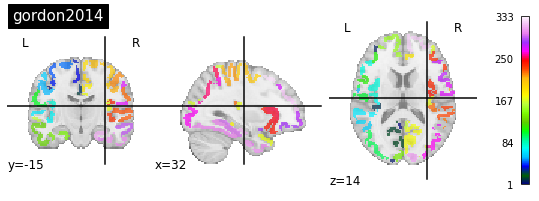

In [7]:
from nilearn import datasets, plotting, image

import matplotlib.pyplot as plt

from python.acnets.parcellations.gordon  import fetch_atlas as fetch_gordon2014_atlas
gordon2014_atlas = fetch_gordon2014_atlas()
# plotting.plot_roi(atlas.maps, title='atlas', colorbar=True)

# atlas = datasets.fetch_atlas_difumo()
# plotting.plot_img(image.load_img(atlas.maps).slicer[...,1])

plotting.plot_roi(gordon2014_atlas.maps, title='gordon2014', colorbar=True)

plt.show()

Computed the network maps! Now plotting networks on glass brain...


100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


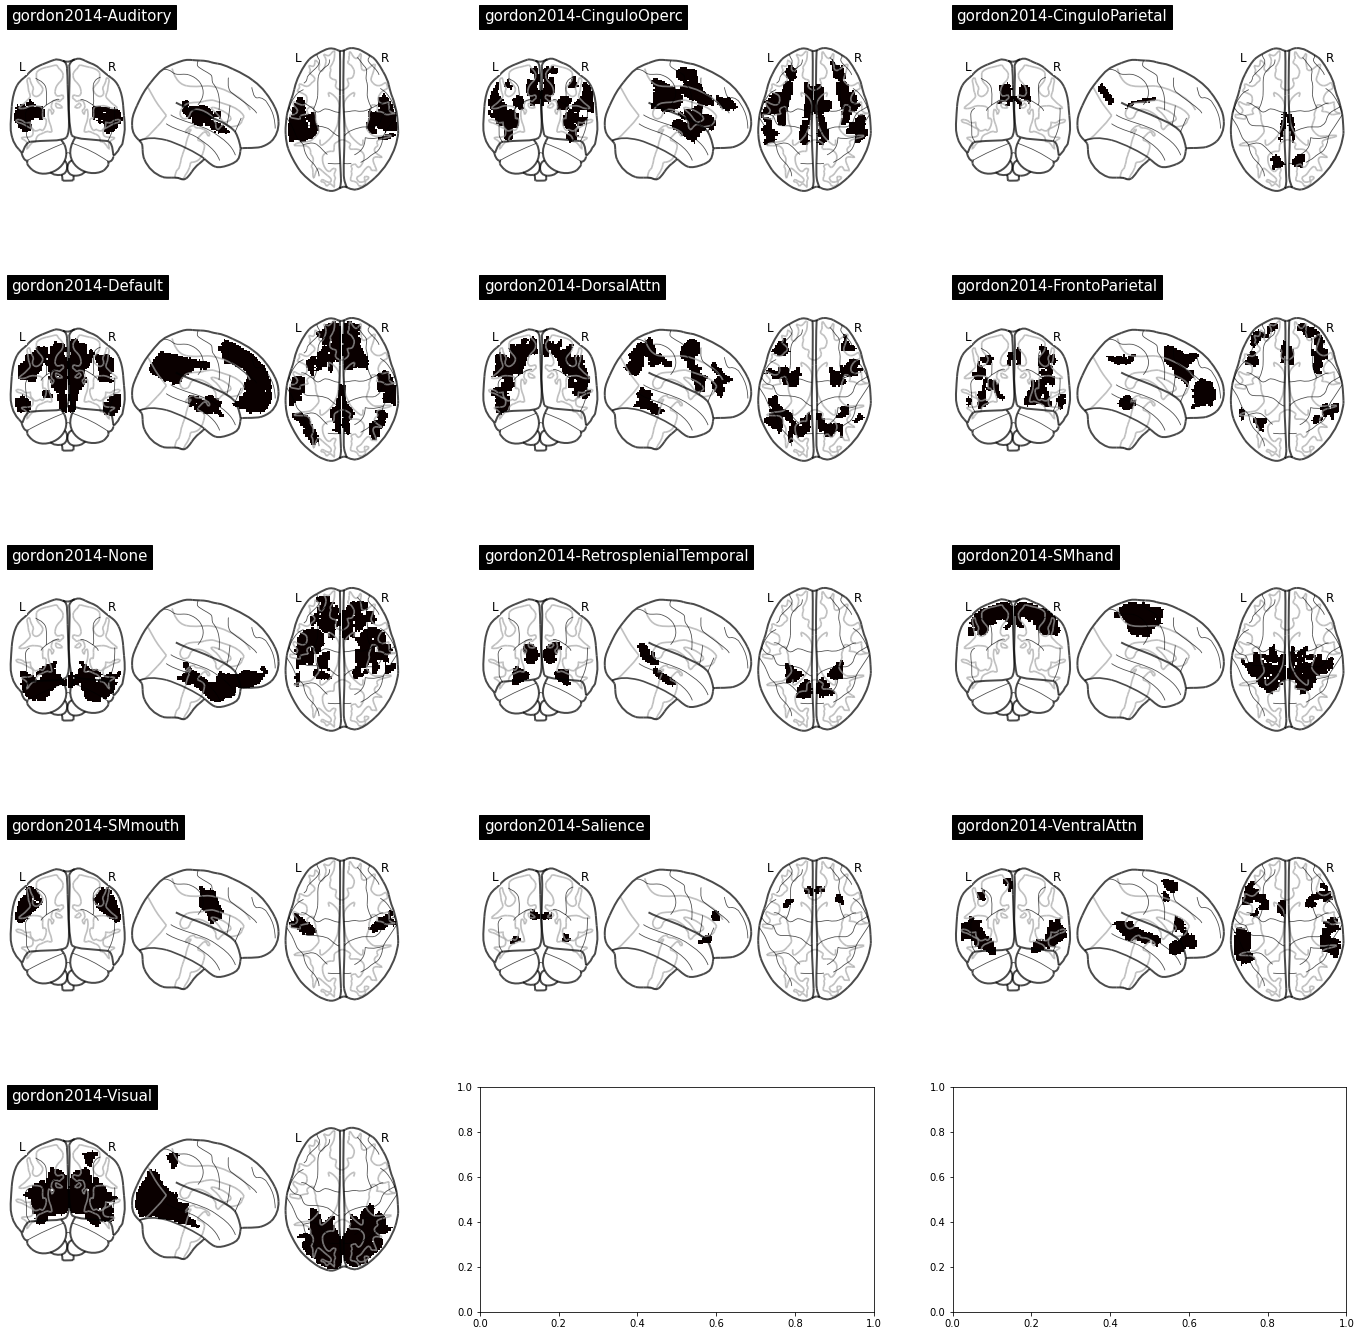

Done! Now plotting networks on MNI...


100%|██████████| 13/13 [00:15<00:00,  1.18s/it]


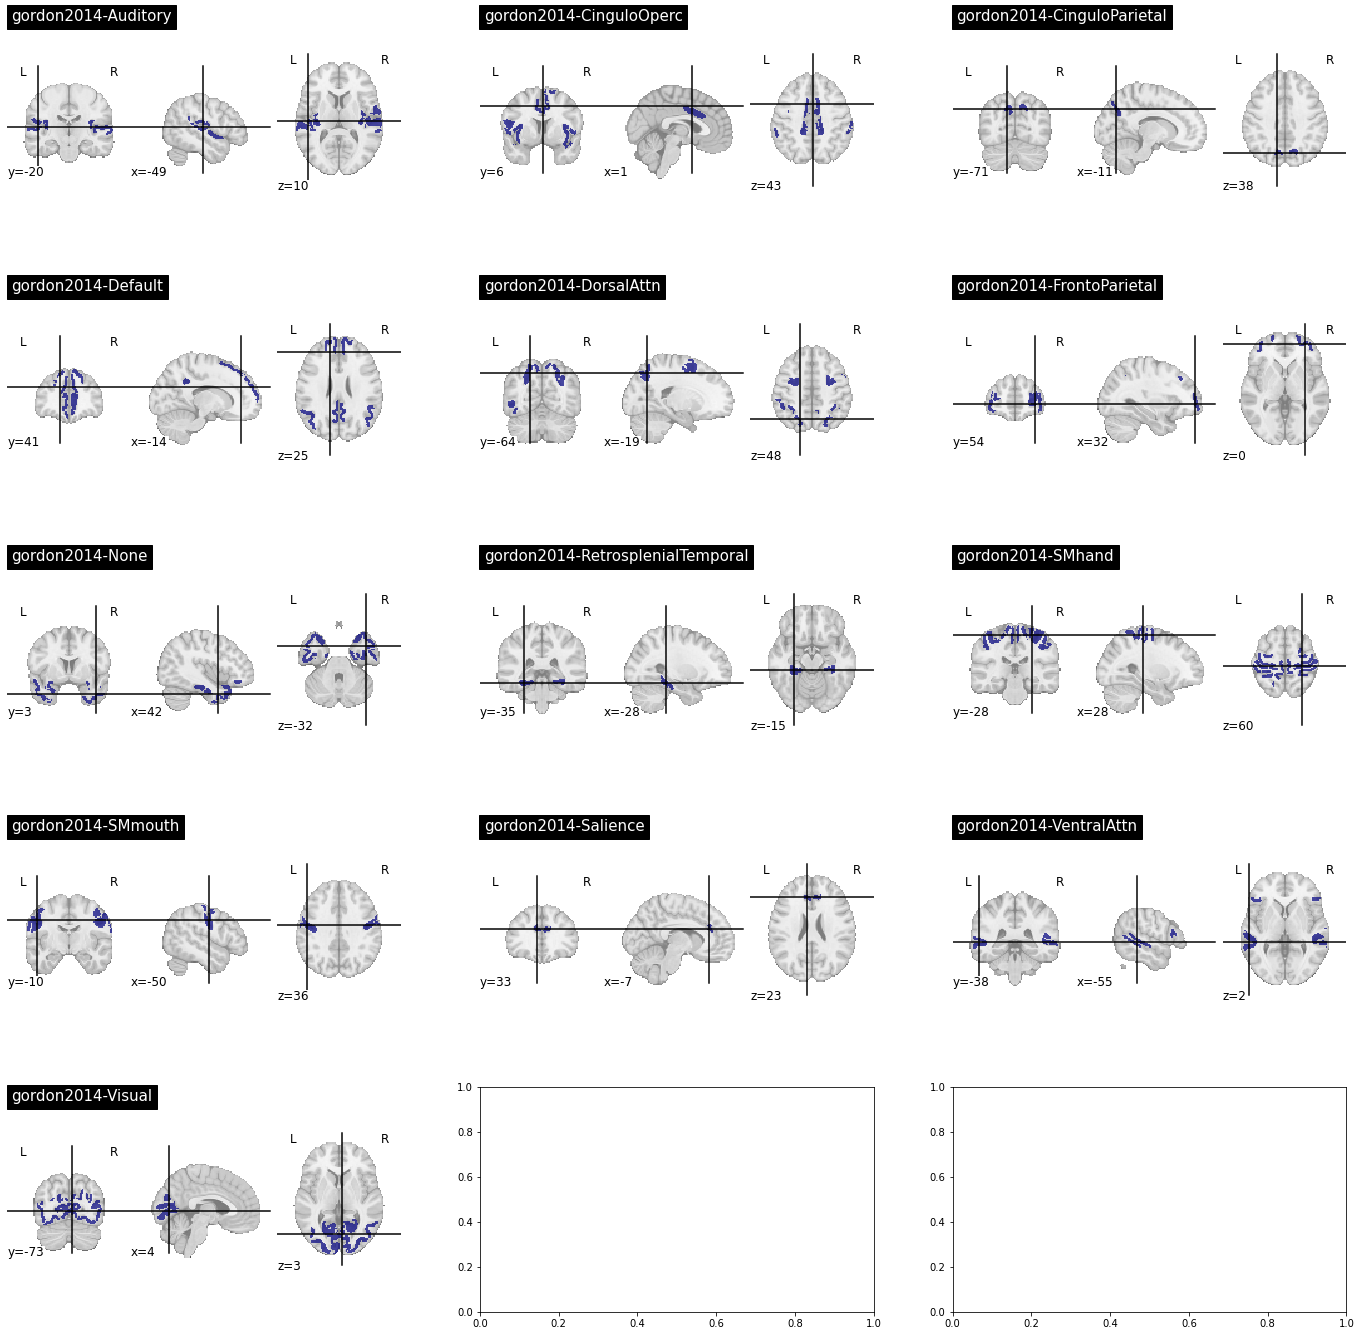

In [15]:
import numpy as np
from tqdm.auto import tqdm


# 1. calculate networks map

gordon_labels = gordon2014_atlas.labels.reset_index()
gordon_labels['network_index'] = gordon_labels['network'].astype('category').cat.codes + 1

network_names = gordon_labels.network.astype('category').cat.categories.to_list()

def reg2net_func(region_index):
    net_index = 0
    if region_index > 0:
        net_index =  gordon_labels[['network_index']].values[int(region_index)-1,0].astype('float')

    return net_index

network_map = image.load_img(gordon2014_atlas.maps).get_fdata().squeeze()
network_map = np.vectorize(reg2net_func)(network_map)
network_map = network_map[..., np.newaxis]

# 2. Networks on glass brain
print('Computed the network maps! Now plotting networks on glass brain...')
fig, axes = plt.subplots(5, 3, figsize=(24, 24))

for i in tqdm(range(1, network_map.max()+1)):
    ax = axes.flatten()[i-1]
    single_network_map = np.where(network_map == i, network_map, 0)
    network_img = image.new_img_like(gordon2014_atlas.maps, single_network_map)

    title = f'gordon2014-{network_names[i-1]}'
    display = plotting.plot_glass_brain(network_img, axes=ax,
                                        title=title, colorbar=False, annotate=True)
plt.show()

# Networks on MNI brain
print('Done! Now plotting networks on MNI...')
fig, axes = plt.subplots(5, 3, figsize=(24, 24))
for i in tqdm(range(1, network_map.max()+1)):
    ax = axes.flatten()[i-1]
    single_network_map = np.where(network_map == i, network_map, 0)
    network_img = image.new_img_like(gordon2014_atlas.maps, single_network_map)

    title = f'gordon2014-{network_names[i-1]}'
    display = plotting.plot_roi(network_img, axes=ax,
                                title=title, colorbar=False, annotate=True)

plt.show()

100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


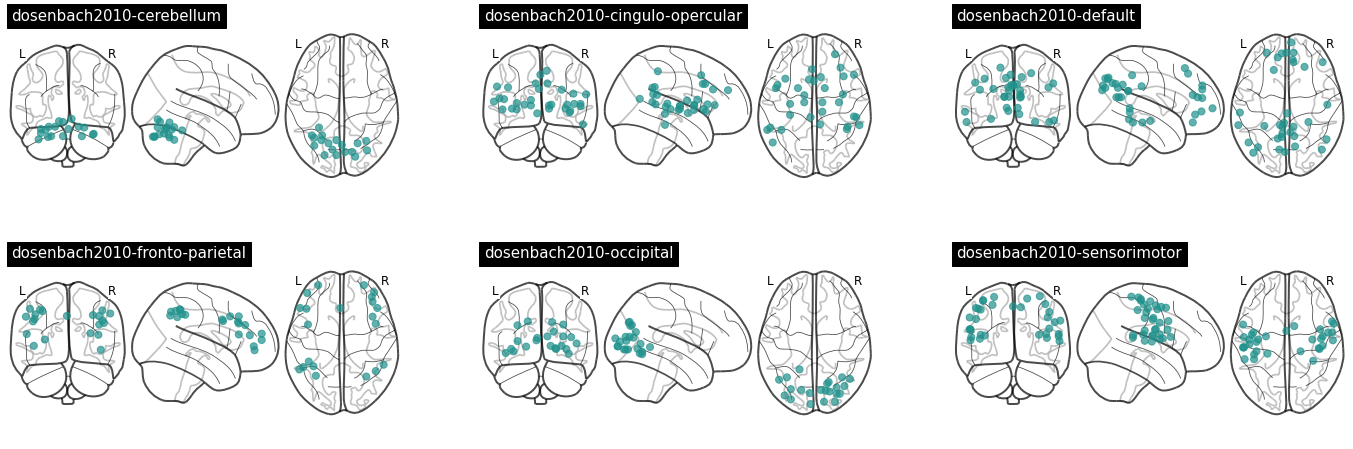

In [41]:
from nilearn import datasets, maskers
from nilearn.maskers.nifti_spheres_masker import _apply_mask_and_get_affinity
from python.acnets.parcellations.dosenbach import load_dosenbach2010_masker
from nilearn.datasets import load_mni152_template

tqdm.pandas()

fig, axes = plt.subplots(2, 3, figsize=(24, 8))

_, dosenbach2010_labels = load_dosenbach2010_masker()

# load MNI152 template
mni152_template = load_mni152_template(resolution=2)
mni152_data = mni152_template.get_fdata()[..., np.newaxis]
mni152_template = image.new_img_like(mni152_template, mni152_data)



def plot_network_mask(regions, mni152=mni152_template):
    """"""
    network_name = regions.name
    network_index = regions['network_index'].unique()[0]
    ax = axes.flatten()[network_index]
    title = f'dosenbach2010-{network_name}'

    
    seeds = regions[['x','y','z']].values

    # plot the actual maskers
    # print(f'Extracting {network_name}...')
    # _, A = _apply_mask_and_get_affinity(seeds, mni152, radius=5, allow_overlap=False)
    # _img = A.toarray().sum(axis=0).reshape(mni152.shape)
    # _img = image.new_img_like(mni152, _img)
    # print(f'Done! Now plotting {network_name}...')
    # plotting.plot_roi(_img, title=title, colorbar=False)
    # plotting.plot_glass_brain(_img, title=title, colorbar=False)
    # plt.show()

    # plot markers
    node_values = np.ones(seeds.shape[0])
    display = plotting.plot_markers(node_values, seeds, title=title, node_size=50, colorbar=False, axes=ax)

dosenbach2010_labels['network_index'] = dosenbach2010_labels.groupby('network').ngroup()
dosenbach2010_labels.groupby('network').progress_apply(lambda regions: plot_network_mask(regions))

plt.show()